In [41]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli

import torchvision
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

# from time import time

# from torch.utils.tensorboard import SummaryWriter

# if gpu is to be used
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cpu


# Paratemer setup

In [45]:
BATCH_SIZE = 128
INPUT_DIM = 28*28
LATENT_DIM = 2

N_EPOCHS = 10
LEARNING_RATE = 1e-3
# BETA = 1

# Dataloader + downloading dataset

In [46]:
root = './resources/mnist'
if not os.path.exists(root):
    os.mkdir(root)
    
def flatten(x: torch.Tensor()):
    return x.view(INPUT_DIM)

transform = transforms.Compose([transforms.ToTensor(),
#                                 flatten
                               ])

train_set = datasets.MNIST(root=root, train=True, transform=transform, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=BATCH_SIZE,
                                           pin_memory=cuda,
#                                            shuffle=True
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=BATCH_SIZE,
                                          pin_memory=cuda,
#                                           shuffle=True
                                         )

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

print('Training samples: {}'.format(len(train_set)))
print('Test samples: {}'.format(len(test_set)))

Training samples: 60000
Test samples: 10000


In [232]:
len(train_set.indices), len(train_loader)

AttributeError: 'MNIST' object has no attribute 'indices'

torch.Size([128, 1, 28, 28])


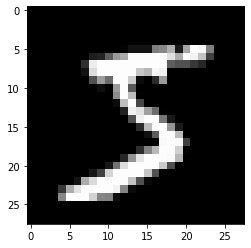

In [47]:
pom, _ = next(iter(train_loader))
print(pom.shape)
plt.imshow(pom[0].view(28,28).numpy(), cmap='gist_gray')

## Inspecting the first iteration of images and labels (not part of the final code)

In [5]:
# get batch of images and labels to find out its shape
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 784])
torch.Size([128])


In [6]:
# Minimum and maximum value in the first image (pixel range)
min(images[0].view(-1)), max(images[0].view(-1))

(tensor(0.), tensor(1.))

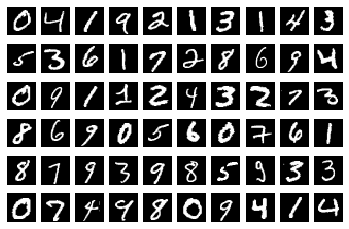

In [7]:
# display 60 images from current iteration
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].view(28,28).numpy().squeeze(), cmap='gist_gray')

In [26]:
images.shape

torch.Size([128, 784])

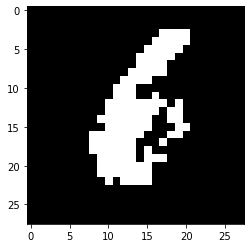

In [40]:
pom = torch.distributions.Bernoulli(images)
pom_sample = pom.sample()
# pom_sample
plt.imshow(pom_sample[1].view(28,28).numpy(), cmap='gist_gray')
# plt.imshow(images[1].view(28,28).numpy(), cmap='gist_gray')

# VAE implementation

In [55]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
#         self.fc1 = nn.Linear(INPUT_DIM, 256)
#         self.fc2 = nn.Linear(256, 128)
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc_mu = nn.Linear(32*24*24, LATENT_DIM)
        self.fc_logvar = nn.Linear(32*24*24, LATENT_DIM)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        x_mu = self.fc_mu(x)
        x_log_var = self.fc_logvar(x)
        
        return x_mu, x_log_var
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(LATENT_DIM, 32*24*24)
        self.conv1 = nn.ConvTranspose2d(32, 16, 3)
        self.conv2 = nn.ConvTranspose2d(16, 1, 3)
#         self.fc2 = nn.Linear(128, 256)
#         self.fc3 = nn.Linear(256, INPUT_DIM)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(x.shape[0], 32, 24, 24)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterize(self, x_mu, x_std):
        q_zx = Normal(x_mu, x_std)
        p_z = Normal(torch.zeros_like(x_mu), torch.ones_like(x_std))
        return q_zx, p_z
        
    def forward(self, x):
        out = dict()
        
        x_mu, x_logvar = self.encoder(x)
        x_std = torch.exp(x_logvar / 2)  # sigma = e^(log_var / 2)

        # q(z|x) = Normal(z | x_mu, x_logvar)
        q_zx = Normal(x_mu, x_std)
        p_z = Normal(torch.zeros_like(x_mu), torch.ones_like(x_std))
#         q_zx, p_z = self.reparameterize(x_mu, x_std)

        # sample from q(z|x) with reparametrization
        z = q_zx.rsample()

        # p(x|z) = Bernoulli()
        z_mu = decoder(z)
        z_mu = z_mu.view(z_mu.shape[0], -1)
        p_xz = Bernoulli(z_mu)
        
        out['q_zx'] = q_zx
        out['p_z'] = p_z
        out['z'] = z
        out['z_mu'] = z_mu
        out['p_xz'] = p_xz
        return out
    
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)

print(encoder)
print(decoder)
print(vae)
n_params_encoder = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
n_params_decoder = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
n_params_vae = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters in encoder: %d' % n_params_encoder)
print('Number of parameters in decoder: %d' % n_params_decoder)
print('Number of parameters in vae: %d' % n_params_vae)

Encoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc_mu): Linear(in_features=18432, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=18432, out_features=2, bias=True)
)
Decoder(
  (fc1): Linear(in_features=2, out_features=18432, bias=True)
  (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (fc_mu): Linear(in_features=18432, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=18432, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=18432, bias=True)
    (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )

Calculate loss (ELBO):
\begin{equation*}
\log p(x) \ge \mathbb{E}_{q(z \mid x)} \left[ \log \frac{p(x \mid z) p(z)}{q(z \mid x)} \right]
\end{equation*}

In [60]:
import torch.optim as optim

def ELBO_loss(x, z, q_zx, p_xz, p_z, **kwargs):
    x = x.view(x.shape[0], -1)
    log_prob_p_xz = p_xz.log_prob(x).sum(dim=1)
    log_prob_p_z = p_z.log_prob(z).sum(dim=1)
    log_prob_q_zx = q_zx.log_prob(z).sum(dim=1)
    loss = -torch.mean(log_prob_p_xz + log_prob_p_z - log_prob_q_zx)
#     print(loss, torch.mean(log_prob_p_xz).item(), torch.mean(log_prob_p_z).item(), torch.mean(log_prob_q_zx).item())
    return loss

# loss_function = nn.MSELoss()
loss_function = ELBO_loss
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

### Test the forward pass

In [50]:
dataiter = iter(train_loader)

In [51]:
images, labels = next(dataiter)
images.shape

torch.Size([128, 1, 28, 28])

In [61]:
# test the forward pass
# images, labels = next(iter(train_loader))
images, labels = next(dataiter)
x = images.to(device)
x = torch.autograd.Variable(x)
out = vae(x)

loss = loss_function(x=x, **out)
loss
# fc_weights_prev = vae.decoder.fc3.weight.data.numpy()
# print(fc_weights_prev.sum())

tensor(607.2458, grad_fn=<NegBackward>)

In [54]:
out['z_mu'].shape, x.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

In [ ]:
# zero the parameter gradients
optimizer.zero_grad()
loss.backward()
print(vae.decoder.fc3.weight.grad)
print(vae.encoder.fc_mu.weight.grad)
print(vae.encoder.fc_logvar.weight.grad)
optimizer.step()

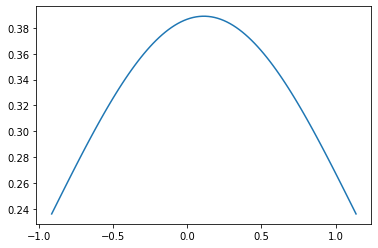

In [78]:
import scipy.stats as stats
pom_mu, pom_sigma = x_mu[0][0].item(), x_std[0][0].item()
pom_x = np.linspace(pom_mu - pom_sigma, pom_mu + pom_sigma, 100)
pom_y = stats.norm.pdf(pom_x, pom_mu, pom_sigma)
plt.plot(x, pom_y)
plt.show()

## Train the network

In [62]:
# train the network
train_loss, train_kl = [], []
valid_loss, valid_kl = [], []

print("Using device:", device)

for epoch in range(N_EPOCHS):
    batch_loss = []
    vae.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        x, labels = data[0].to(device), data[1].to(device)
        
        # forward + backward + optimize
        out = vae(x)
        loss = loss_function(x=x, **out)
#         print('loss: ', loss)
#         print(vae.decoder.fc1.weight.data.numpy().sum())
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
#         print(vae.decoder.fc1.weight.grad.sum())
        optimizer.step()
        
        batch_loss.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
#             print(loss.item(), log_prob_p_xz.item(), log_prob_p_z.item(), log_prob_q_zx.item())
            running_loss = 0.0
    
    train_loss.append(np.mean(batch_loss))
    
    with torch.no_grad():
        vae.eval()
        batch_loss = []
        
#         for data in test_loader:
        data = next(iter(test_loader))
        x, labels = data[0].to(device), data[1].to(device)

        out = vae(x)
        
        loss = loss_function(x=x, **out)
        
        batch_loss.append(loss.item())
        valid_loss.append(np.mean(batch_loss))
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = out['z_mu'].detach().to("cpu")
        z = out['z'].detach().to("cpu").numpy()


Using device: cpu
[1,   100] loss: 450.483
[1,   200] loss: 387.589
[1,   300] loss: 343.713
[1,   400] loss: 292.570
[2,   100] loss: 248.389
[2,   200] loss: 237.380
[2,   300] loss: 227.338
[2,   400] loss: 221.991
[3,   100] loss: 215.193
[3,   200] loss: 212.977
[3,   300] loss: 208.446
[3,   400] loss: 206.488
[4,   100] loss: 203.335
[4,   200] loss: 202.614
[4,   300] loss: 199.392
[4,   400] loss: 198.250
[5,   100] loss: 196.081
[5,   200] loss: 196.004
[5,   300] loss: 193.234
[5,   400] loss: 192.448
[6,   100] loss: 190.726
[6,   200] loss: 190.951
[6,   300] loss: 188.517
[6,   400] loss: 187.923
[7,   100] loss: 186.221
[7,   200] loss: 186.732
[7,   300] loss: 184.477
[7,   400] loss: 184.095
[8,   100] loss: 182.575
[8,   200] loss: 183.304
[8,   300] loss: 181.168
[8,   400] loss: 180.983
[9,   100] loss: 179.606
[9,   200] loss: 180.632
[9,   300] loss: 178.569
[9,   400] loss: 178.548
[10,   100] loss: 177.315
[10,   200] loss: 178.473
[10,   300] loss: 176.544
[10,

### Train & validation loss and KL

[Text(0, 0.5, 'loss'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Training & validation loss (from 2nd epoch)')]

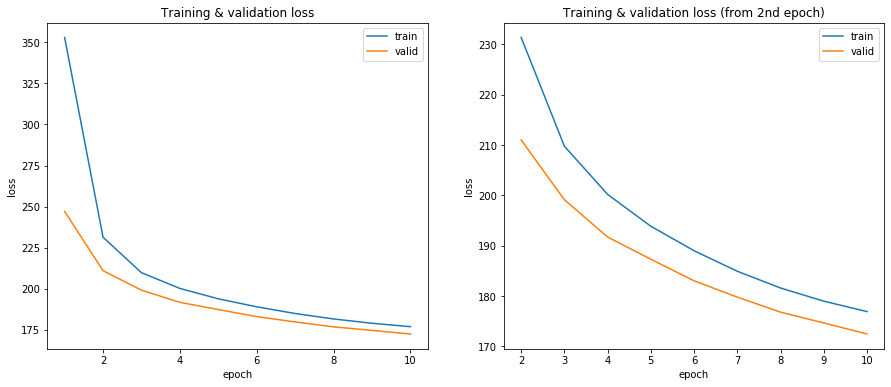

In [63]:
# Results for convolution layers
vae.eval()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x = range(1, epoch + 2)
sns.lineplot(x=x, y=train_loss, ax=ax[0], label="train")
sns.lineplot(x=x, y=valid_loss, ax=ax[0], label="valid")
ax[0].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss")

sns.lineplot(x=x[1:], y=train_loss[1:], ax=ax[1], label="train")
sns.lineplot(x=x[1:], y=valid_loss[1:], ax=ax[1], label="valid")
ax[1].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss (from 2nd epoch)")

[Text(0, 0.5, 'loss'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Training & validation loss (from 2nd epoch)')]

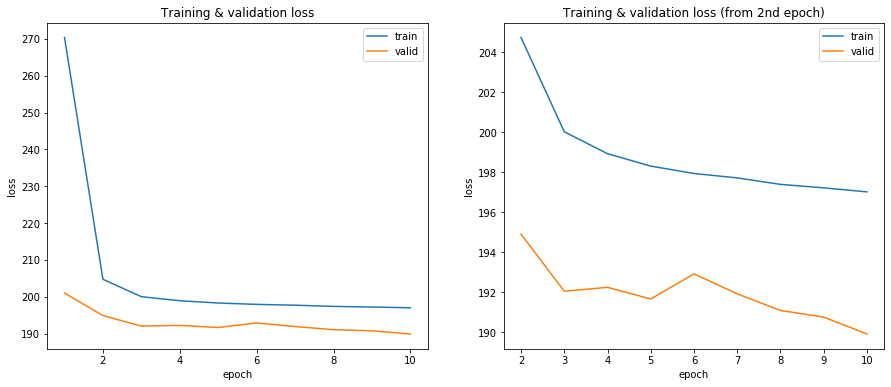

In [21]:
# Results for linear layers
vae.eval()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x = range(1, epoch + 2)
sns.lineplot(x=x, y=train_loss, ax=ax[0], label="train")
sns.lineplot(x=x, y=valid_loss, ax=ax[0], label="valid")
ax[0].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss")

sns.lineplot(x=x[1:], y=train_loss[1:], ax=ax[1], label="train")
sns.lineplot(x=x[1:], y=valid_loss[1:], ax=ax[1], label="valid")
ax[1].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss (from 2nd epoch)")

### Latent space visualization

In [407]:
images.shape

torch.Size([128, 784])

In [408]:
from sklearn.decomposition import PCA

agg_mu = torch.tensor([])
agg_mu_1 = []
agg_mu_2 = []
agg_l = []

with torch.no_grad():
    it = iter(test_loader)
    for i in range(50):
        images, labels = next(it)
        x = images.view(images.shape[0], -1)
        latent_mu, _ = torch.chunk(net.encoder(x), 2, dim=-1)
        agg_mu = torch.cat((agg_mu, latent_mu), dim=0)
        if latent_mu.shape[1] > 2:
            latent_mu = PCA(n_components=2).fit_transform(latent_mu.numpy())
        agg_mu_1 += list(latent_mu[:,0])
        agg_mu_2 += list(latent_mu[:,1])
        agg_l += list(labels.numpy())

# pom_images, pom_labels = next(iter(test_loader))
# pom_images.shape, pom_labels.shape
len(agg_mu_1), len(agg_mu_2), len(agg_l), agg_mu.shape

NameError: name 'net' is not defined

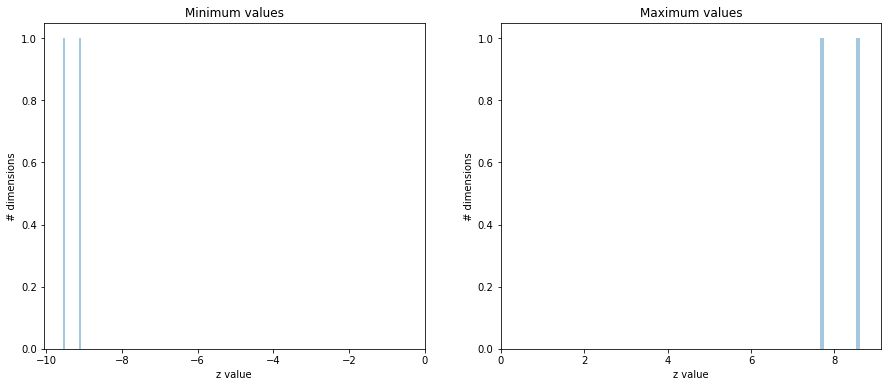

In [332]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mins = torch.min(agg_mu, dim=0).values.numpy()
sns.distplot(mins, bins=10, kde=False, ax=ax[0])
ax[0].set_xlim((mins.min() - 0.5, 0))
ax[0].set(xlabel="z value",
          ylabel="# dimensions",
          title="Minimum values")

maxs = torch.max(agg_mu, dim=0).values.numpy()
sns.distplot(maxs, bins=10, kde=False, ax=ax[1])
ax[1].set_xlim((0, maxs.max() + 0.5))
ax[1].set(xlabel="z value",
          ylabel="# dimensions",
          title="Maximum values")

plt.show()

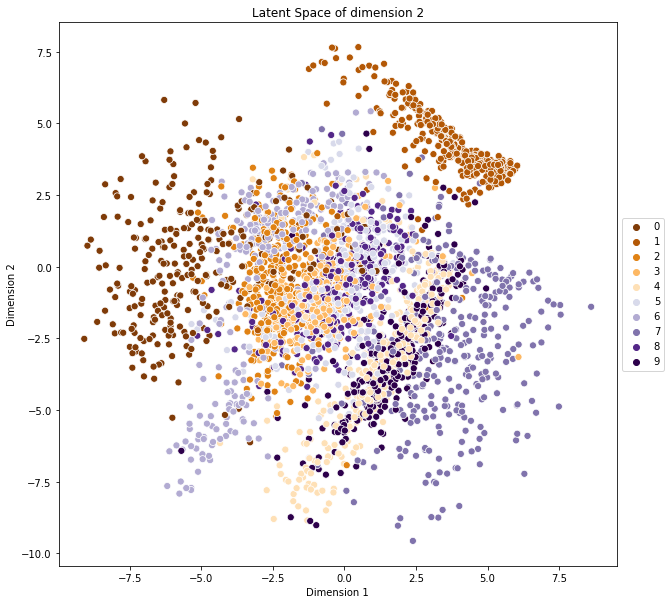

In [333]:
colors = ['#7f3b08','#b35806','#e08214','#fdb863','#fee0b6','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b']
pal = sns.color_palette(colors)

f, ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(ax=ax, x=agg_mu_1, y=agg_mu_2, hue=agg_l, palette=pal, s=50)
ax.set_title('Latent Space of dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

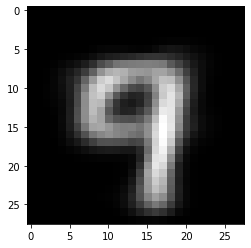

In [334]:
with torch.no_grad():
    z = torch.tensor([2.0, -5.0])
    plt.imshow(net.decoder(z).view(28,28), cmap='gist_gray')

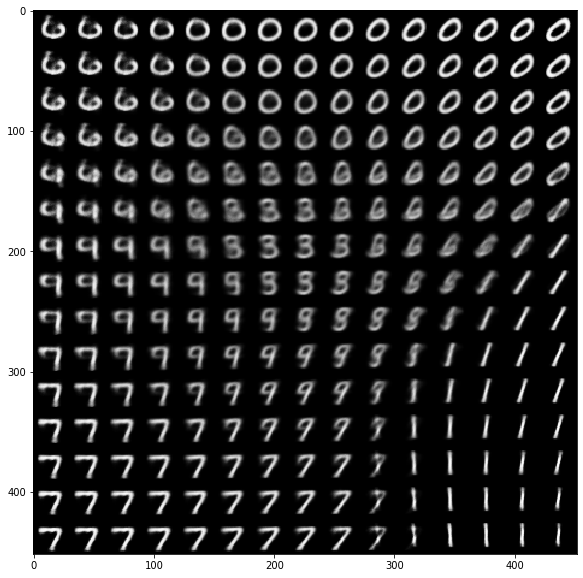

In [335]:
# sample images representing the whole latent space
n_samples_sqrt = 15

f, ax = plt.subplots(1, figsize=(10,10))
with torch.no_grad():
    xs = np.linspace(mins[0], maxs[0], num=n_samples_sqrt)
    ys = np.linspace(mins[1], maxs[1], num=n_samples_sqrt)
    
    sample = torch.tensor([(x, y) for x in xs for y in ys]).float()
    sample = net.decoder(sample).view(n_samples_sqrt**2,1,28,28)
    img = torchvision.utils.make_grid(sample, nrow=n_samples_sqrt).numpy()
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray_r')

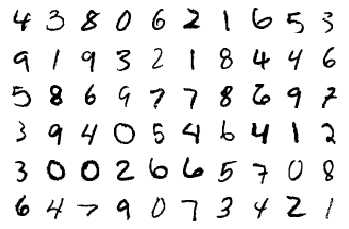

In [336]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

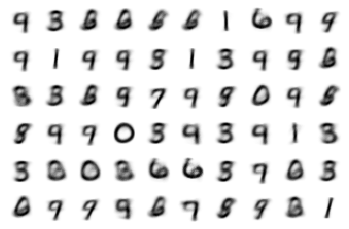

In [337]:
with torch.no_grad():
    x_hat, mu, log_var, z = net(images)
    figure = plt.figure()
    num_of_images = 60
    for index in range(1, num_of_images + 1):
        plt.subplot(6, 10, index)
        plt.axis('off')
        plt.imshow(x_hat[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# Latent space samples
f, ax = plt.subplots(1)
ax.set_title('Samples from latent space')
ax.axis('off')

with torch.no_grad():
    epsilon = torch.from_numpy(grid).float().to(device)
    samples = torch.sigmoid(net.decoder(epsilon)).detach()

canvas = np.zeros((28*rows, columns*28))
for i in range(rows):
    for j in range(columns):
        idx = i % columns + rows * j
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
ax.imshow(canvas, cmap='gray')

In [173]:
epsilon.shape, z.shape

(torch.Size([64, 2]), torch.Size([64, 8]))

In [ ]:
train_loss, valid_loss

In [ ]:
len(val_loader)

In [ ]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    out_images, mu, log_var = net(images)
    imshow(torchvision.utils.make_grid(images))
    imshow(torchvision.utils.make_grid(out_images))
    print('GroundTruth: ', ' '.join('%5d' % labels[j] for j in range(8)))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(predicted)

In [ ]:
print(labels)

In [ ]:
(predicted == labels).squeeze()

In [ ]:
# generate new image based on latent space
with torch.no_grad():
    sample = torch.randn(64,10)
    sample = net.decoder(sample)
    imshow(torchvision.utils.make_grid(sample.view(64,1,28,28)))

In [ ]:
# find accuracy for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of class %d : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
net.zero_grad()  # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)